# Solving Krussel-Smith with Deep Equilibrium Nets
*Simon Lebastard, 02/07/2023*

## Krussel-Smith (1998) model
In the KS'98 model, we look a flavour of the stochastic growth model with a continuum of households under partially uninsurable risk.

**Demand side**
$$V(c) = \mathrm{E}_0\Big[\sum_{t=0}^{\infty}{\beta^t U(c_t)}\Big]$$
with
$$U(c) = \lim_{\nu \to \sigma}{\frac{c^{1-\nu} - 1}{1 - \nu}}$$

Agents are each endowed with $\epsilon \tilde{l}$ units of labor per period, where $\epsilon$ is a first-order Markov chain. (In K&S'98, $\epsilon$ can only take two values: 0 and 1, representing unemployed and employed idiosyncratic states, respectively).
As a very large number of agents is consided, and by assumed independence of the idiosyncratic shocks, K&S'98 assume that the total number of employed and unemployed people remain constant over time. That is, there is no aggregate fluctuations of jobs supply.

Idiosyncratic endogenous state: $k$ holding of capital
Idiosyncratic exogenous state: $\epsilon$ at the individual level
$\Gamma$ the joint distribution of idiosyncratic states $(k,\epsilon)$

Given the aggregate states (see $z$ defined below), the consumer's optimization problem is:
$$v(k,\epsilon;\Gamma,z) = \max_{c,k'}{ \Big\{ U(c) + \beta\mathrm{E}\Big[v(k',\epsilon';\Gamma',z') \mid z,\epsilon \Big] \Big\} } $$
under budget constraint, rational expectations wrt law of motion and non-negative capital holding.

The budget constraint writes:
$$c+k' = r(\hat{k},\hat{l},z)k + w(\hat{k},\hat{l},z)\tilde{l}\epsilon + (1-\delta)k$$

**Supply side**
A single-type good is produced using two factors of production: labor $l$ and capital $k$.
The good is produced according to a Cobb-Douglas production function:
$$y = zk^{\alpha}l^{1-\alpha}, \quad \alpha \in [0,1]$$
The TFP is stochastic and coresponds to the source of aggregate risk. In K&S'98, two aggregate states are considered: $(z_b, z_g)$.
Again, $z$ follows a first-order Markov chain.

We assume the production market to be competitive, such that wages $w$ and rental rates $r$, both functions of aggregate states, are respectively determined by:
$$w(\hat{k},\hat{l},z) = (1 - \alpha)z(\frac{\hat{k}}{\hat{l}})^\alpha$$
$$r(\hat{k},\hat{l},z) = \alpha z(\frac{\hat{k}}{\hat{l}})^{\alpha-1}$$

Here we assume that as the population of households is infinitely large, the share of unemployed remains constant. Moreover, here consumers have no disutility from labor, implying that the labor supply at each period is constant at $L_s = N*\mathrm{E}\big[\epsilon\big]$.
We have the market clearing condition for the capital/cons good: $$\int{(c(k,\epsilon;\Gamma,z) + k'(k,\epsilon;\Gamma,z))dF(\Gamma)} = (1-\delta)\int{k dF(\Gamma)} + z\int{k dF(\Gamma)}^{\alpha}L_s^{1-\alpha}$$

For both Markov chains, we assume the economy is already running at the stationary distribution.

**Law of motion**
$$\Gamma' = H(\Gamma,z,z')$$


### Formulating the problem for solving with DEN
Here we will consider two "implicit" policy functions for which we solve:
- Next-period capital $k'(k,\epsilon;\Gamma,z)$
- The Lagrange multiplier on the next-period capital non-negativity constraint: $\mu_k(k,\epsilon;\Gamma,z)$
- The Lagrange multiplier on the positivity of current-period consumption, ie of the residual of the budget constraint: $\mu_c(k,\epsilon;\Gamma,z)$

As in Azinovic et al, we simulate $N$ agents, and index $i \in [1,...,N]$.

#### Idiosyncratic error terms
The Euler equation can be obtained by taking the FOC of the consumer's objective function with respect to next-period capital:
$$1 = \beta(1-\delta)\mathrm{E}\Big[\Big(\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}\Big)^{\nu} \mid z,\epsilon\Big] - \big(\mu_c(k,\epsilon;\Gamma,z) - \mu_k(k,\epsilon;\Gamma,z) \big)c(k,\epsilon;\Gamma,z)^{\nu}$$

Based on that, we defined the Euler error as:
$$e_{EE}(k,\epsilon,\Gamma,z) \equiv \bigg[\beta(1-\delta)\mathrm{E}\Big[\Big(\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}\Big)^{\nu} \mid z,\epsilon\Big] - \big(\mu_c(k,\epsilon;\Gamma,z) - \mu_k(k,\epsilon;\Gamma,z) \big)\bigg]^{-\frac{1}{\nu}} - 1$$
and
$$e_{EE,i} \equiv e_{EE}(k_i,\epsilon_i,\Gamma,z)$$
Here we want to train the model to capture binding constraints by itself. Note that in practice, during training we may end up with negative consumptions (that will be penalized), such that ratio $\frac{c(k,\epsilon;\Gamma,z)}{c(k',\epsilon';\Gamma',z')}^\nu$ may not be defined for $\nu \in \mathbb{R}$.
To solve this issue, I use RELU activation in the last two layers of the network, to enforce $c(k,\epsilon;\Gamma,z), k'(k,\epsilon;\Gamma,z), \mu_c(k,\epsilon;\Gamma,z), \mu_k(k,\epsilon;\Gamma,z)$ to be non-negative for all states.

We define the error on the complementary-slackness condition on k as:
$$e_{CS_k}(k,\epsilon,\Gamma,z) \equiv \frac{\mu_k(k,\epsilon;\Gamma,z)}{U'(\bar{c})} \frac{k'(k,\epsilon;\Gamma,z)}{\bar{k}}$$
and
$$e_{CS_k,i} \equiv e_{CS_k}(k_i,\epsilon_i,\Gamma,z)$$

We define the error on the complementary-slackness condition on c as:
$$e_{CS_c}(k,\epsilon,\Gamma,z) \equiv \frac{\mu_c(k,\epsilon;\Gamma,z)}{U'(\bar{c})} \frac{c(k,\epsilon;\Gamma,z)}{\bar{c}}$$
and
$$e_{CS_c,i} \equiv e_{CS_c}(k_i,\epsilon_i,\Gamma,z)$$

The agent's budget constraint is:
$$e_{BC}(k,\epsilon,\Gamma,z) \equiv \frac{1}{\hat{c}+\hat{k}}\bigg[ c + k' - \big( 1 + r(\hat{k}, \hat{l}, z) - \delta \big)k - w(\hat{k}, \hat{l}, z)\tilde{l}\epsilon \bigg] $$

#### Aggregate error term
At each period, we compute the aggregate $K \equiv \sum_{i=1}^{N}{k_i}$

One way to proceed could be to define an error based on the market clearing condition on capital. Instead, we will enforce consumption to satisfy the market clearing condition at each period. Note that in doing so, we could still need to enforce that consumption is positive. Instead of enforcing a new constraint on a Lagrangian multiplier associated with consumption, I compute the error on MC by constraining consumption to be positive in the error, by using a transformation of the error that satisfies:
$$\lim_{c \downarrow 0}{e_{MC}(c)} = \infty$$
This should prevent consumption from ever being non-positive.

We define the error on the market clearing condition as:
$$e_{MC} \equiv \sum_{i=1}^{N}{\Big[c(k_i,\epsilon_i;\Gamma,z) + k'(k_i,\epsilon_i;\Gamma,z)\Big]} - zK^{\alpha}(Nu)^{1-\alpha} - (1-\delta)K$$

We also define the error on the aggregate law of motion as:
$$e_{LM} \equiv $$

#### Defining the loss function
On a batch $\mathcal{D}_{train}$, the loss function is defined as:
$$l(\theta) \equiv \frac{1}{\mid\mathcal{D}_{train}\mid} \sum_{x \in \mathcal{D}_{train}}{\frac{1}{N-1}\sum_{i=1}^{N}{\Big(e_{EE,i}^2 + e_{CS_k,i}^2 + e_{CS_c,i}^2\Big)} + e_{MC}^2}$$

**Note: alternative implementation**<br>
Instead of having a policy variable for the Lagrange multiplier on the positivity of next-period capital, we could have a transformation function on  next-period capital that ensures it remains non-negative at all times. I will implement this alternative method and compare results.

#### Network architecture
The network architecture is composite, with one subnetwork tasked with learning a useful representation of the distribution of capital holdings, and a second agent-network tasked with learning agent's policy on next-period capital and consumption.

**Distribution representation network**
- $1+N$ scalar inputs: $(z, \big\{k_i\big\}_{i \in [1..N]})$
- $n_{repr,distr}$ scalar outputs

**Policy network**
- $n_{repr,distr} + 2$ scalar inputs, with agent-specific inputs being $(\epsilon_i, k_i)$
- 4 scalar outputs: $(k_i', {\mu_{k}}_i, c_i, {\mu_{c}}_i)$

In [1]:
# Import modules
import os
import re
from datetime import datetime

import tensorflow as tf
tf.config.run_functions_eagerly(True)
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Model
from keras.layers import * #Input, Dense, BatchNormalization
from tensorflow import Tensor

# Set the seed for replicable results
seed = 0
np.random.seed(seed)
#tf.set_random_seed(seed)

2023-02-13 14:19:14.267755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from utils import Z, z_l, z_h, P_z, E, eps_l, eps_h, P_eps, draw_z, draw_eps, firm

# Other constants
α = tf.constant(0.3, dtype=tf.float32)
β = tf.constant(0.7, dtype=tf.float32)
δ = tf.constant(0.1, dtype=tf.float32)
γ = tf.constant(2.0, dtype=tf.float32)

2023-02-13 14:19:21.571736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Neural Network - Architecture

The following is a specialization class of Keras' Model, with a custom training step with gradient taping

In [4]:
@tf.function
def budget_residual(k: Tensor, c: Tensor, eps:Tensor, kp: Tensor, r:float, w:float):
    return w*eps + (1+r-δ)*k - kp - c

@tf.function
def FB(a:float, b:float):
    return a + b - tf.sqrt(tf.pow(a,2) + tf.pow(b,2))

class DENModel(Model):

    @tf.function
    def __init__(self, n_aggr_repr:int, optimizer, N:int, *args, **kwargs):
        self.N = N
        self.distr_repr_dim = n_aggr_repr
        self.optimizer = optimizer

        initializer = tf.keras.initializers.GlorotUniform()

        ## AGGREGATE REPRESENTATION UNITS
        # Common network processes distribution-relevant information
        x_aggr = Input(shape=(self.N+1, ), name='Distr-In')
        #xn_aggr = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)(x_aggr)
        aggr_1 = Dense(units=8*self.distr_repr_dim, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense1')(x_aggr)
        aggr_2 = Dense(units=8*self.distr_repr_dim, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense2')(aggr_1)
        aggr_3 = Dense(units=4*self.distr_repr_dim, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense3')(aggr_2)
        aggr_4 = Dense(units=self.distr_repr_dim, activation = 'tanh', kernel_initializer=initializer, name='Distr-Dense4')(aggr_3)

        ## POLICY UNITS
        # Agent-specific policy units
        x_idio = Input(shape = (2, ), name='Idio-In')
        combined = Concatenate(name='Intermediate_Input')([aggr_4, x_idio])
        interp_c_h_1 = Dense(units=32, input_dim=2+self.distr_repr_dim, activation = 'tanh', kernel_initializer=initializer, name='Policy-Dense1')(combined)
        interp_c_h_2 = Dense(units=32, activation = 'tanh', kernel_initializer=initializer, name='Policy-Dense2')(interp_c_h_1)
        interp_c_h_3 = Dense(units=32, activation = 'relu', kernel_initializer=initializer, name='Policy-Relu1')(interp_c_h_2)
        policy = Dense(units=4, activation = 'relu', kernel_initializer=initializer, name='Policy-Relu2')(interp_c_h_3)

        super().__init__(inputs = [x_aggr,x_idio], outputs= policy, *args, **kwargs)

    @tf.function
    def initialize_k(self):
        k_ss = 2.
        return tf.Variable(tf.random.uniform(shape=[self.N,], minval=0.8*k_ss, maxval=1.2*k_ss))

    @tf.function
    def _forward_DEPRECATED(self, z:Tensor, k:Tensor, eps:Tensor, training:bool=False):
        kp = tf.Variable(tf.zeros_like(k))
        mup = tf.Variable(tf.zeros_like(k))
        c = tf.Variable(tf.zeros_like(k))
        lambdap = tf.Variable(tf.zeros_like(k))

        x_aggr = tf.concat([z[None],k],axis=0)
        x_aggr = tf.reshape(x_aggr, shape=[1,-1])
        for agent_id in range(self.N):
            x_idio = tf.concat([k[agent_id][None], eps[agent_id][None]], axis=0)
            x_idio = tf.reshape(x_idio, shape=[1,-1])
            pol = self(inputs=(x_aggr, x_idio), training=training)
            kp[agent_id].assign(pol[0,0])
            mup[agent_id].assign(pol[0,1])
            c[agent_id].assign(pol[0,2])
            lambdap[agent_id].assign(pol[0,3])
        return kp, mup, c, lambdap

    @tf.function
    def forward(self, z:Tensor, k:Tensor, eps:Tensor, training:bool=False):
        x_aggr = tf.concat([z[None],k],axis=0)
        x_aggr = tf.tile(tf.reshape(x_aggr, shape=[1,-1]), tf.constant([self.N,1], tf.int32))
        
        x_idio = tf.concat([tf.reshape(k,[-1,1]),tf.reshape(eps,[-1,1])],axis=1)
        y = self(inputs=(x_aggr, x_idio), training=training)
        return y

    @tf.function
    def residuals(self, z:Tensor, k:Tensor, eps:Tensor):
        K = tf.math.reduce_sum(k)
        if K<0:
            print("K: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!")
        Y,r,w = firm(K,z)
        #print("CURRENT-PERIOD AGGREGATE CAPITAL")
        #print(K)
        #print("CURRENT-PERIOD PRODUCTION, ROC, WAGE")
        #print(Y,r,w)

        # 1st forward pass
        yp = self.forward(z, k, eps, training=True)
        kp = yp[:,0]
        mup = yp[:,1]
        c = yp[:,2]
        lambdap = yp[:,3]
        C = tf.math.reduce_sum(c)
        Kp = tf.math.reduce_sum(kp)
        if Kp<0:
            print("Kp: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!")
        BUDGET_RES = budget_residual(k, c, eps, kp, r, w)
        CSK_RES = mup*kp
        CSC_RES = c*lambdap

        # For each possible value of next-period exogenous states, compute the next-period policy
        kpp = tf.Variable(tf.zeros((self.N,2)))
        Kpp = tf.Variable(tf.zeros((2,)))
        mupp = tf.Variable(tf.zeros((self.N,2)))
        lambdapp = tf.Variable(tf.zeros((self.N,2)))
        cp = tf.Variable(tf.zeros((self.N,2)))
        Cp = tf.Variable(tf.zeros((2,)))
        ee_comp = tf.Variable(tf.zeros((self.N,2)))
        # BUDGET_RES_COND = np.zeros((N,2))
        # CSK_RES_COND = np.zeros((N,2))
        # CSC_RES_COND = np.zeros((N,2))
        # MC_RES_COND = np.zeros((N,2))

        for zp_id, zp in enumerate(Z):
            Yp,rp,wp = firm(Kp,zp)
            epsp = draw_eps(self.N)
            ypp = self.forward(zp, kp, epsp, training=True)
            kpp[:,zp_id].assign(ypp[:,0])
            mupp[:,zp_id].assign(ypp[:,1])
            cp[:,zp_id].assign(ypp[:,2])
            lambdapp[:,zp_id].assign(ypp[:,3])
            ee_comp_tmp = tf.pow(c/cp[:,zp_id],γ)
            ee_comp[:,zp_id].assign(tf.where(tf.math.is_nan(ee_comp_tmp), 1e6*tf.ones_like(ee_comp_tmp), ee_comp_tmp))
            # BUDGET_RES_COND[:,zp_id] = budget_residual(kp, ypp[2], epsp, ypp[0], rp, wp)
            # CSK_RES_COND[:,zp_id] = mupp[:,zp_id]*kpp[:,zp_id]
            # CSC_RES_COND[:,zp_id] = cp[:,zp_id]*lambdapp[:,zp_id]

            Kpp[zp_id].assign(tf.math.reduce_sum(kpp[:,zp_id]))
            if Kpp[zp_id]<0:
                print("Kpp[{0:d}]: NEGATIVE AGGREGATE CAPITAL DESPITE RELU!!".format(zp_id))
            Cp[zp_id].assign(tf.math.reduce_sum(cp[:,zp_id]))
            # MC_RES_COND[zp_id] = Cp[zp_id] + Kpp[zp_id] - (1-δ)*Kp - Yp
        
        EE_RES = tf.pow(
            β*(1-δ)*tf.tensordot(ee_comp,tf.transpose(P_z[int(z==z_h),:]), axes=1) - (lambdap - mup),
            -1./γ
        ) - 1
        
        MC_RES = C + Kp - (1-δ)*K - Y
        return BUDGET_RES, CSK_RES, CSC_RES, MC_RES

    @tf.function
    def train_step(self, data, batch_size):
        z, k, eps = data
        ERR = 0
        for per_id in range(batch_size):
            y = self.forward(z, k, eps, training=False)
            BUDGET_RES, CSK_RES, CSC_RES, MC_RES = self.residuals(z, k, eps)
            # print("BUDGET RESIDUAL: ", BUDGET_RES*BUDGET_RES)
            # print("CS on K: ", CSK_RES*CSK_RES)
            # print("CS on C: ", CSC_RES*CSC_RES)
            # print("MK: ", MC_RES*MC_RES)
            # print("TOTAL ERROR FORM IS SOURCES: ", tf.math.reduce_mean(BUDGET_RES*BUDGET_RES + CSK_RES*CSK_RES + CSC_RES*CSC_RES))
            ERR += (1./batch_size)*tf.math.reduce_mean(BUDGET_RES*BUDGET_RES + CSK_RES*CSK_RES + CSC_RES*CSC_RES) + MC_RES*MC_RES
            k = y[:,0]
            eps = draw_eps(self.N)
            z = draw_z(z)
        return ERR, z, k, eps
    
    @tf.function
    def train(self, n_epochs=1000, freq_out:int=50, batch_size: int=64):
        z = z_h
        eps = draw_eps(self.N)
        k = self.initialize_k()
        self.den_metrics = {
            'mse': [],
            'distr': [],
        }

        for epoch in tqdm(range(n_epochs)):
            with tf.GradientTape() as tape:
                ERR, z, k, eps = self.train_step([z, k, eps], batch_size)
            grads = tape.gradient(ERR, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.den_metrics['mse'].append(ERR.numpy())
            self.den_metrics['distr'].append(k.numpy())

            # Log every 200 batches.
            if epoch % freq_out == 0:
                print(
                    "Training loss (for one batch) at epoch %d: %.4f"
                    % (epoch, float(ERR))
                )
                print("Total # time iterations: %d" % (batch_size*(1+epoch)))
            
        return self.den_metrics
    
adam_optim = tf.keras.optimizers.Adam(
    learning_rate=0.00001,
)
adagrad_optim = tf.keras.optimizers.Adagrad(learning_rate=0.0001)
sgd_optim = tf.keras.optimizers.experimental.SGD(learning_rate=0.0001)

### Compact network approach

In [5]:
N = num_agents = 500
L = N*tf.reduce_mean(E)
initializer = tf.keras.initializers.GlorotUniform()

model_w2 = DENModel(n_aggr_repr=2, N=500, optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
model_w2.summary()

model_w4 = DENModel(n_aggr_repr=4, N=500, optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
model_w4.summary()

model_w8 = DENModel(n_aggr_repr=8, N=500, optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
model_w8.summary()

Model: "den_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Distr-In (InputLayer)          [(None, 501)]        0           []                               
                                                                                                  
 Distr-Dense1 (Dense)           (None, 16)           8032        ['Distr-In[0][0]']               
                                                                                                  
 Distr-Dense2 (Dense)           (None, 16)           272         ['Distr-Dense1[0][0]']           
                                                                                                  
 Distr-Dense3 (Dense)           (None, 8)            136         ['Distr-Dense2[0][0]']           
                                                                                          

/Users/slebst/opt/miniconda3/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "den_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Distr-In (InputLayer)          [(None, 501)]        0           []                               
                                                                                                  
 Distr-Dense1 (Dense)           (None, 32)           16064       ['Distr-In[0][0]']               
                                                                                                  
 Distr-Dense2 (Dense)           (None, 32)           1056        ['Distr-Dense1[0][0]']           
                                                                                                  
 Distr-Dense3 (Dense)           (None, 16)           528         ['Distr-Dense2[0][0]']           
                                                                                        

### Model training - Impact of distribution representation dimensionality

In [6]:
model_w2.train(n_epochs=1500, freq_out=50, batch_size=8)

  0%|          | 1/1500 [00:00<17:42,  1.41it/s]

Training loss (for one batch) at epoch 0: 1662182.3750
Total # time iterations: 8


  3%|▎         | 51/1500 [00:24<11:18,  2.14it/s]

Training loss (for one batch) at epoch 50: 159303.7656
Total # time iterations: 408


  7%|▋         | 101/1500 [00:53<12:23,  1.88it/s]

Training loss (for one batch) at epoch 100: 135995.9531
Total # time iterations: 808


 10%|█         | 151/1500 [01:16<09:52,  2.28it/s]

Training loss (for one batch) at epoch 150: 110686.9141
Total # time iterations: 1208


 13%|█▎        | 201/1500 [01:38<09:38,  2.25it/s]

Training loss (for one batch) at epoch 200: 79557.8984
Total # time iterations: 1608


 17%|█▋        | 251/1500 [02:03<09:19,  2.23it/s]

Training loss (for one batch) at epoch 250: nan
Total # time iterations: 2008


 20%|██        | 301/1500 [02:25<08:51,  2.26it/s]

Training loss (for one batch) at epoch 300: nan
Total # time iterations: 2408


 23%|██▎       | 351/1500 [02:48<08:49,  2.17it/s]

Training loss (for one batch) at epoch 350: nan
Total # time iterations: 2808


 27%|██▋       | 401/1500 [03:11<08:46,  2.09it/s]

Training loss (for one batch) at epoch 400: nan
Total # time iterations: 3208


 30%|███       | 451/1500 [03:34<08:11,  2.14it/s]

Training loss (for one batch) at epoch 450: nan
Total # time iterations: 3608


 33%|███▎      | 501/1500 [03:56<07:37,  2.19it/s]

Training loss (for one batch) at epoch 500: nan
Total # time iterations: 4008


 37%|███▋      | 551/1500 [04:19<07:09,  2.21it/s]

Training loss (for one batch) at epoch 550: nan
Total # time iterations: 4408


 40%|████      | 601/1500 [04:42<06:49,  2.19it/s]

Training loss (for one batch) at epoch 600: nan
Total # time iterations: 4808


 43%|████▎     | 651/1500 [05:05<06:30,  2.17it/s]

Training loss (for one batch) at epoch 650: nan
Total # time iterations: 5208


 47%|████▋     | 701/1500 [05:29<06:08,  2.17it/s]

Training loss (for one batch) at epoch 700: nan
Total # time iterations: 5608


 50%|█████     | 751/1500 [05:52<05:46,  2.16it/s]

Training loss (for one batch) at epoch 750: nan
Total # time iterations: 6008


 53%|█████▎    | 801/1500 [06:16<05:24,  2.16it/s]

Training loss (for one batch) at epoch 800: nan
Total # time iterations: 6408


 57%|█████▋    | 851/1500 [06:39<05:03,  2.14it/s]

Training loss (for one batch) at epoch 850: nan
Total # time iterations: 6808


 60%|██████    | 901/1500 [07:03<04:43,  2.11it/s]

Training loss (for one batch) at epoch 900: nan
Total # time iterations: 7208


 63%|██████▎   | 951/1500 [07:27<04:18,  2.13it/s]

Training loss (for one batch) at epoch 950: nan
Total # time iterations: 7608


 67%|██████▋   | 1001/1500 [07:51<04:20,  1.91it/s]

Training loss (for one batch) at epoch 1000: nan
Total # time iterations: 8008


 70%|███████   | 1051/1500 [08:16<03:33,  2.10it/s]

Training loss (for one batch) at epoch 1050: nan
Total # time iterations: 8408


 73%|███████▎  | 1101/1500 [08:40<03:11,  2.08it/s]

Training loss (for one batch) at epoch 1100: nan
Total # time iterations: 8808


 77%|███████▋  | 1151/1500 [09:04<02:50,  2.04it/s]

Training loss (for one batch) at epoch 1150: nan
Total # time iterations: 9208


 80%|████████  | 1201/1500 [09:28<02:23,  2.08it/s]

Training loss (for one batch) at epoch 1200: nan
Total # time iterations: 9608


 83%|████████▎ | 1251/1500 [09:53<02:00,  2.07it/s]

Training loss (for one batch) at epoch 1250: nan
Total # time iterations: 10008


 87%|████████▋ | 1301/1500 [10:17<01:35,  2.09it/s]

Training loss (for one batch) at epoch 1300: nan
Total # time iterations: 10408


 90%|█████████ | 1351/1500 [10:42<01:12,  2.05it/s]

Training loss (for one batch) at epoch 1350: nan
Total # time iterations: 10808


 93%|█████████▎| 1401/1500 [11:07<00:49,  1.99it/s]

Training loss (for one batch) at epoch 1400: nan
Total # time iterations: 11208


 97%|█████████▋| 1451/1500 [11:31<00:24,  1.99it/s]

Training loss (for one batch) at epoch 1450: nan
Total # time iterations: 11608


100%|██████████| 1500/1500 [11:56<00:00,  2.09it/s]


{'mse': ListWrapper([1662182.4, 184065.62, 183893.2, 183370.62, 182826.42, 182270.86, 181707.34, 181182.77, 180684.66, 180186.28, 179685.06, 179181.58, 178676.33, 178169.62, 177661.77, 177152.95, 176643.4, 176133.23, 175622.6, 175111.56, 174600.31, 174088.73, 173577.12, 173065.44, 172553.7, 172041.97, 171530.33, 171018.73, 170507.27, 169995.92, 169484.73, 168973.72, 168462.86, 167952.19, 167441.78, 166931.52, 166421.48, 165911.69, 165402.12, 164892.77, 164383.66, 163874.7, 163366.02, 162857.53, 162349.25, 161841.17, 161333.34, 160825.67, 160318.19, 159810.89, 159303.77, 158796.78, 158289.97, 157783.3, 157276.78, 156775.89, 156313.17, 155871.73, 155435.53, 154995.45, 154552.12, 154105.9, 153657.28, 153206.53, 152753.86, 152299.42, 151843.39, 151385.9, 150927.05, 150466.88, 150005.48, 149542.86, 149079.05, 148614.11, 148148.0, 147680.75, 147214.33, 146755.88, 146313.06, 145867.62, 145416.05, 144959.92, 144496.78, 144029.86, 143559.34, 143085.67, 142611.48, 142138.14, 141664.89, 141195.3,

In [7]:
model_w4.train(n_epochs=1500, freq_out=50, batch_size=8)

  0%|          | 0/1500 [00:00<?, ?it/s]


KeyError: 'The optimizer cannot recognize variable Distr-Dense1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'

In [8]:
model_w8.train(n_epochs=1500, freq_out=50, batch_size=8)

  0%|          | 0/1500 [00:00<?, ?it/s]


KeyError: 'The optimizer cannot recognize variable Distr-Dense1/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'

### Impact of batch size

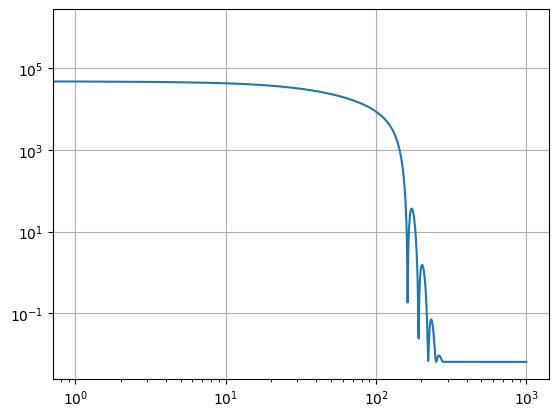

In [36]:
#fig, ax = plt.subplots(1,1)
plt.plot(
    range(1500),
    model_w2.dne_metrics['mse'],
)
plt.xscale('log')
plt.yscale('log')
plt.grid()

In [1]:
def plot_policy(model:DENModel):
    k_ss = 2
    fig, axes = plt.subplots(2,2, figsize=(14,14))
    k_grid = np.linspace(0.7*k_ss, 1.3*k_ss, 300)
    yp = model.forward(z_l, tf.Variable(k_grid), draw_eps(model.N))
    axes[0,0].plot(
        k_grid,
        yp[:,0].numpy()
    )
    axes[0,1].plot(
        k_grid,
        yp[:,1].numpy()
    )
    axes[1,0].plot(
        k_grid,
        yp[:,2].numpy()
    )
    axes[1,1].plot(
        k_grid,
        yp[:,3].numpy()
    )

def plot_distribution(model:DENModel):
    fig, ax = plt.subplot(figsize=(14,14))
    ax.hist(
        model.den_metrics['distr']
    )

NameError: name 'DENModel' is not defined

### Alternative architecture: Brute-force MC-Distribution-processing neural network

In [21]:
# n_aggr_reprb = 8

## AGGREGATE REPRESENTATION UNITS
## Common network processes distribution-relevant information
# x_aggrb = Input(shape = (None,2))
# xn_aggrb = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,)(x_aggr)
# aggr_1b = Dense(4*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(xn_aggr)
# aggr_2b = Dense(4*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_1)
# aggr_3b = Dense(2*n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_2)
# aggr_4b = Dense(n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(aggr_3)

## POLICY UNITS
# Agent-specific policy units
# x_idiob = Input(shape = (None,2*N))
# interp_c_h_1b = Dense(32, input_dim=2*N+n_aggr_reprb, activation = 'tanh', kernel_initializer=initializer)(tf.concat(values=(x_idiob,aggr_4b),axis=1))
# interp_c_h_2b = Dense(32, activation = 'tanh', kernel_initializer=initializer)(interp_c_h_1b)
# policyb = Dense(2*N, activation = 'tanh', kernel_initializer=initializer)(interp_c_h_2b)

# nn2 = DENModel(inputs = tf.concat(values=(x_aggrb,x_idiob)), outputs= policyb)